In [68]:
import pandas as pd
## from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Uncomment to load data without google
df = pd.read_csv('convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')
population_df = pd.read_csv('chicago_population.CSV', ';').T
headers = population_df.iloc[0]
population_df = pd.DataFrame(population_df.values[1:], columns=headers)
population_df['name'] = population_df['name'].str.upper().str.replace("'", "")

/var/folders/z1/jzc991l54w39yxvw6723tyhm0000gn/T/ipykernel_69662/414773780.py:2: DtypeWarning: Columns (14,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')
/Users/hannahzhang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


**LOAD DATA**

In [3]:
# load MCMF data

## drive.mount('/content/drive', force_remount=True)
## df = pd.read_csv('/content/drive/MyDrive/STAT 390/convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')
df = pd.read_csv('convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')

/var/folders/z1/jzc991l54w39yxvw6723tyhm0000gn/T/ipykernel_69662/3311080947.py:5: DtypeWarning: Columns (14,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('convert_MCMF_ALL_TIME_DATA.csv', sep = '\t')


In [4]:
# load population data (used to calculate per capita metrics)
population_df = pd.read_csv('chicago_population.CSV', ';').T
headers = population_df.iloc[0]
population_df = pd.DataFrame(population_df.values[1:], columns=headers)
population_df['name'] = population_df['name'].str.upper().str.replace("'", "")

/Users/hannahzhang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
temp1 = df['Geographic Cluster Name'].sort_values().unique()
temp1

array(['ALBANY PARK', 'ARCHER HEIGHTS', 'ARMOUR SQUARE', 'ASHBURN',
       'AUBURN GRESHAM', 'AUSTIN', 'AVALON PARK', 'AVONDALE',
       'BELMONT CRAGIN', 'BEVERLY', 'BRIDGEPORT', 'BRIGHTON PARK',
       'BURNSIDE', 'Back of the Yards', 'Bronzeville/South Lakefront',
       'CALUMET HEIGHTS', 'CHATHAM', 'CHICAGO LAWN', 'CLEARING',
       'DOUGLAS', 'DUNNING', 'EAST GARFIELD PARK', 'EAST SIDE',
       'EDGEWATER', 'EDISON PARK', 'ENGLEWOOD', 'FOREST GLEN',
       'FULLER PARK', 'GAGE PARK', 'GARFIELD PARK', 'GARFIELD RIDGE',
       'GRAND BOULEVARD', 'GREATER GRAND CROSSING', 'HEGEWISCH',
       'HERMOSA', 'HUMBOLDT PARK', 'HYDE PARK', 'IRVING PARK',
       'JEFFERSON PARK', 'KENWOOD', 'LAKE VIEW', 'LINCOLN PARK',
       'LINCOLN SQUARE', 'LOGAN SQUARE', 'LOOP', 'LOWER WEST SIDE',
       'Little Village', 'MCKINLEY PARK', 'MONTCLARE', 'MORGAN PARK',
       'MOUNT GREENWOOD', 'NEAR NORTH SIDE', 'NEAR SOUTH SIDE',
       'NEAR WEST SIDE', 'NORTH CENTER', 'NORTH LAWNDALE', 'NORTH PARK',
  

In [6]:
temp2 = population_df['name'].sort_values().unique()
temp2

array(['ALBANY PARK', 'ARCHER HEIGHTS', 'ARMOUR SQUARE', 'ASHBURN',
       'AUBURN GRESHAM', 'AUSTIN', 'AVALON PARK', 'AVONDALE',
       'BELMONT CRAGIN', 'BEVERLY', 'BRIDGEPORT', 'BRIGHTON PARK',
       'BURNSIDE', 'CALUMET HEIGHTS', 'CHATHAM', 'CHICAGO LAWN',
       'CLEARING', 'DOUGLAS', 'DUNNING', 'EAST GARFIELD PARK',
       'EAST SIDE', 'EDGEWATER', 'EDISON PARK', 'ENGLEWOOD',
       'FOREST GLEN', 'FULLER PARK', 'GAGE PARK', 'GARFIELD RIDGE',
       'GRAND BOULEVARD', 'GREATER GRAND CROSSING', 'HEGEWISCH',
       'HERMOSA', 'HUMBOLDT PARK', 'HYDE PARK', 'IRVING PARK',
       'JEFFERSON PARK', 'KENWOOD', 'LAKE VIEW', 'LINCOLN PARK',
       'LINCOLN SQUARE', 'LOGAN SQUARE', 'LOOP', 'LOWER WEST SIDE',
       'MCKINLEY PARK', 'MONTCLARE', 'MORGAN PARK', 'MOUNT GREENWOOD',
       'NEAR NORTH SIDE', 'NEAR SOUTH SIDE', 'NEAR WEST SIDE', 'NEW CITY',
       'NORTH CENTER', 'NORTH LAWNDALE', 'NORTH PARK', 'NORWOOD PARK',
       'OAKLAND', 'OHARE', 'PORTAGE PARK', 'PULLMAN', 'RIVERDALE',
 

In [7]:
# Explore differences in community areas before merging population data and main data
set(temp1) ^ set(temp2)

{'Back of the Yards',
 'Bronzeville/South Lakefront',
 'GARFIELD PARK',
 'Little Village',
 'NEW CITY',
 'SOUTH LAWNDALE',
 nan}

In [8]:
# Standardize area names
replace_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront'}
replace_pop_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront', 'SOUTH LAWNDALE': 'Little Village', 'NEW CITY': 'Back of the Yards'}
df['Geographic Cluster Name'] = df['Geographic Cluster Name'].replace(replace_df)
population_df['name'] = population_df['name'].replace(replace_pop_df)

# Merge datasets
merged_df = pd.merge(df, population_df, left_on = 'Geographic Cluster Name', right_on = 'name', how = 'left')

**PREPROCESSING**

In [9]:
# Discard programs with min age over 25
df = df.loc[df['Min Age'] <= 25]

# Record programs with max age over 25 as family programs
df['Family Program'] = (df['Max Age'] > 25).astype(bool)

# Make category names unique
category_dict = {'Building And Fixing Things': 'Building & Fixing Things', 
 'Computers.': 'Computers', 
 'Food.': 'Food',
 'Helping Your Community.': 'Helping Your Community',
 'Reading & Writing.': 'Reading & Writing',
 'Sports + Wellness.': 'Sports & Wellness',
 'Work + Career': 'Work & Career'
}

df['Category Name'] = df['Category Name'].replace(category_dict)

# Group category names by STEM
stem_categories = ['Computers', 'Science', 'Building & Fixing Things', 'Science & Math', 'Digital Media.', 'Nature.', 'Math']
df['STEM'] = df['Category Name'].isin(stem_categories)
df['STEM'] = df['STEM'].map({True: 'STEM', False: 'Non-STEM'})

# Group min and max age by quartile
df['Min Age Quartile'] = pd.cut(df['Min Age'], bins=[0, 10, 17, 99, 200], labels=['0-10', '11-17','18-99', '100-200'])
df['Max Age Quartile'] = pd.cut(df['Max Age'], bins=[0, 3, 6, 13, 25], labels=['0-3', '4-6', '7-13','14-25'])

**ANALYSIS**

In [10]:
# Exploring null values
df.isnull().sum()

# Examining the two observations without category names
df.loc[df['Program Name'] == 'Grab & Go Meals for Children & Teens']
df.loc[df['Program Name'] == 'Trunk or Treat at Shabbona']

# Examining observations with missing Geographic cluster names
geonan = df.loc[df['Geographic Cluster Name'].isnull()]
geonan.isnull().sum()

# Checking observations without geographic cluster name and no online address
geoonlinenan = geonan.loc[geonan['Online Address'].isnull()].groupby(by = 'Category Name')
num = geoonlinenan['Category Name'].count()

# Checking the actual category names
categories = df.groupby(by = 'Category Name')
categories['Category Name'].count()

# Locating observations with min_age = 25
df['Min Age'].dtype
df.loc[df['Min Age'] == 25]

,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Program Pays Participants,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food,Family Program,STEM,Min Age Quartile,Max Age Quartile
12050,"11,579",85023,NaN,Game Room at Hamilton,Challenge your friends to more than just board...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.762798,-87.637703,False,True,Non-STEM,18-99,NaN
15844,"16,008",89171,NaN,Basketball - Open at Addams #SpringForward,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN
16789,"16,703",89798,NaN,Game Room at Hamilton,Challenge your friends to more than just board...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.762798,-87.637703,False,True,Non-STEM,18-99,NaN
17021,"18,207",90776,NaN,Pickleball at Gompers,Pickleball is a racquet sport which combines e...,Chicago Park District,Sports & Wellness,4.0,25,99,...,Not Paid,NO,NO,41.975800,-87.734398,False,True,Non-STEM,18-99,NaN
17029,"18,274",90838,NaN,Roller Skating at Ada,Adults skate around the park for recreational fun,Chicago Park District,Sports & Wellness,15.0,25,99,...,Not Paid,NO,NO,41.688400,-87.655998,False,True,Non-STEM,18-99,NaN
17778,"18,208",90777,NaN,Pickleball at Gompers,Pickleball is a racquet sport which combines e...,Chicago Park District,Sports & Wellness,4.0,25,99,...,Not Paid,NO,NO,41.975800,-87.734398,False,True,Non-STEM,18-99,NaN
18119,"16,009",89172,NaN,Basketball - Open at Addams,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN
18639,"18,209",90778,NaN,Pickleball at Gompers,Pickleball is a racquet sport which combines e...,Chicago Park District,Sports & Wellness,4.0,25,99,...,Not Paid,NO,NO,41.975800,-87.734398,False,True,Non-STEM,18-99,NaN
19413,"16,010",89173,NaN,Basketball - Open at Addams,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN
19724,"16,011",89174,NaN,Basketball - Open at Addams,Gym facility is available for open play of bas...,Chicago Park District,Sports & Wellness,10.0,25,99,...,Not Paid,NO,NO,41.863098,-87.659698,False,True,Non-STEM,18-99,NaN


<AxesSubplot:xlabel='Average Latitude', ylabel='Total Programs'>

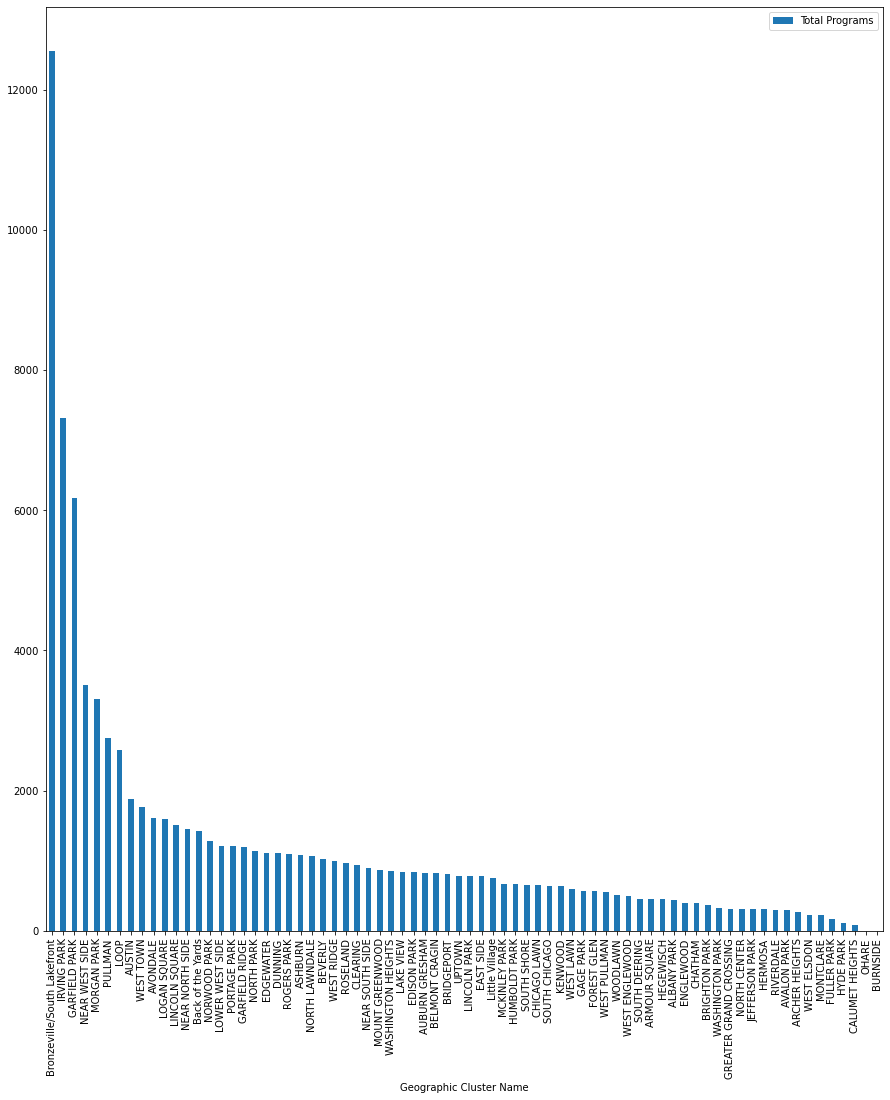

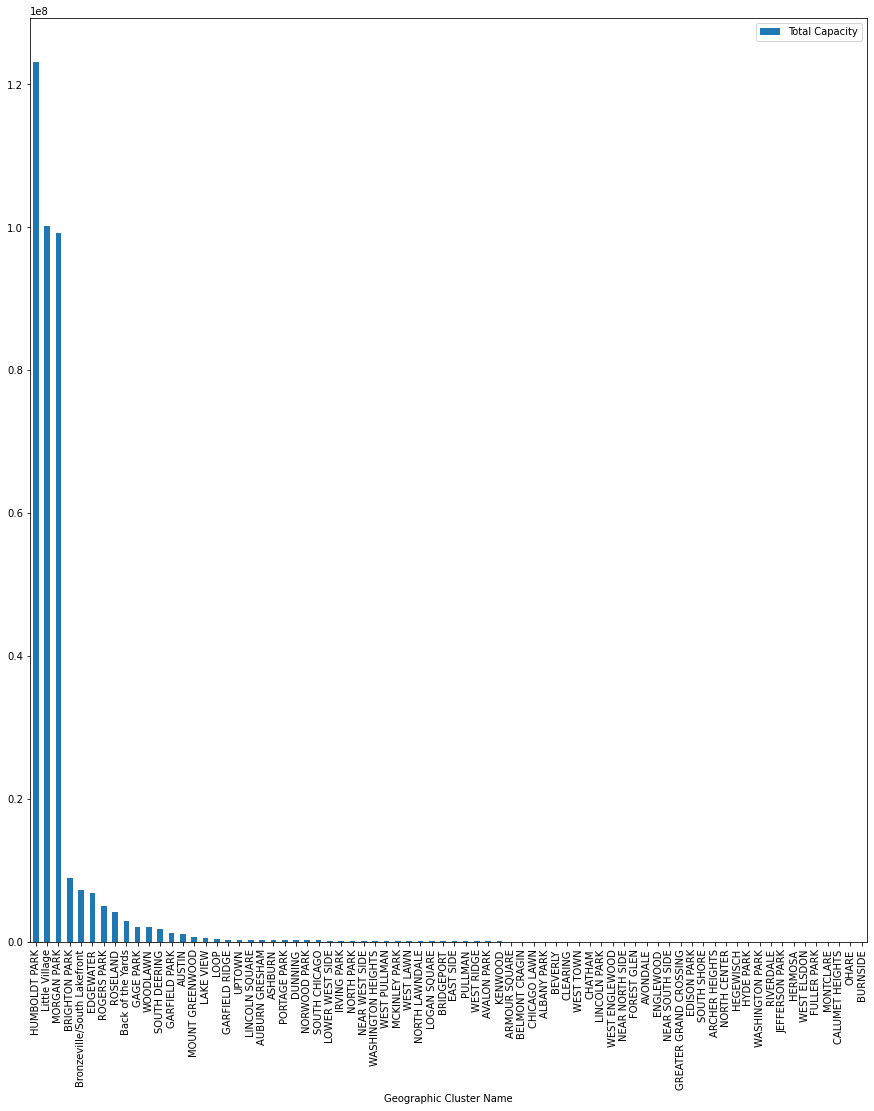

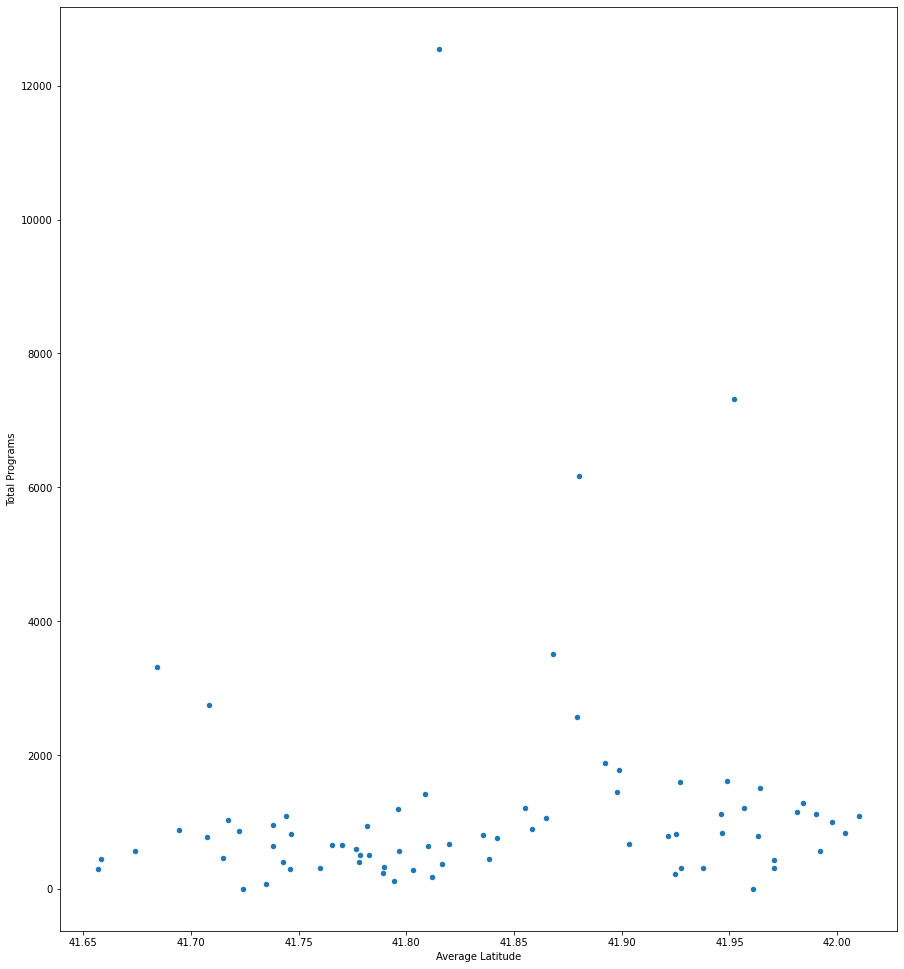

In [17]:
clusters = merged_df.groupby('Geographic Cluster Name').agg({'Geographic Cluster Name': 'count', 'Capacity':'sum', 'Max Age':'mean', 'Latitude':'mean'})
clusters.columns = ['Total Programs', 'Total Capacity', 'Average Max Age', 'Average Latitude']
clusters['Average Capacity'] = clusters['Total Capacity'] / clusters['Total Programs']
clusters.sort_values('Total Programs', inplace=True, ascending=False)
clusters.reset_index(inplace=True)

# Train on total capacity for different program types?
    # Cluster, Type, 
    # Make a binary column for online/in-person
    
# Add population for per capita
clusters.plot.bar(x='Geographic Cluster Name', y='Total Programs', figsize = (15,17))
clusters.sort_values('Total Capacity', ascending=False).plot.bar(x='Geographic Cluster Name', y='Total Capacity', figsize = (15,17))
clusters.plot(kind='scatter', x='Average Latitude', y='Total Programs', figsize = (15,17))


In [18]:
# Train on total capacity for different program types

    ## Important Predictors- what to group by?
    # Cluster (location)
    # Category (make subcategories?)
    # Binary online/in-person
    
    ## Other features to create/use?
    # Time of the year?
    # Price?
    
    ## 
    # Other predictors?
    # Other metrics/interactions to analyze?

grouped = merged_df.groupby(['Geographic Cluster Name', 'Category Name', 'Meeting Type']).agg({'Geographic Cluster Name': 'count', 'Capacity':'sum', 'Max Age':'mean', 'Latitude':'mean'})
grouped.columns = ['Total Programs', 'Total Capacity', 'Average Max Age', 'Average Latitude']
grouped['Average Capacity'] = grouped['Total Capacity'] / grouped['Total Programs']


grouped.reset_index(inplace=True)

grouped['Geographic Cluster Name'] = grouped['Geographic Cluster Name'].replace(replace_df)

# This grouped dataframe will evolve with new enigneered predictors and metrics. We will use this as out training data to assess equity moving forward
merge = pd.merge(grouped, population_df, left_on = 'Geographic Cluster Name', right_on = 'name', how = 'left')
merge

,Geographic Cluster Name,Category Name,Meeting Type,Total Programs,Total Capacity,Average Max Age,Average Latitude,Average Capacity,name,population,income,latinos,blacks,white,asian,other
0,ALBANY PARK,Academic Support,face_to_face,14,210.0,7.928571,41.973703,15.000000,ALBANY PARK,51542,46198,0.494,0.04,0.292,0.144,0.029
1,ALBANY PARK,Building & Fixing Things,face_to_face,1,99.0,99.000000,41.968399,99.000000,ALBANY PARK,51542,46198,0.494,0.04,0.292,0.144,0.029
2,ALBANY PARK,Computers.,face_to_face,5,3930.0,18.600000,41.968393,786.000000,ALBANY PARK,51542,46198,0.494,0.04,0.292,0.144,0.029
3,ALBANY PARK,Healthcare,face_to_face,2,20.0,99.000000,41.973715,10.000000,ALBANY PARK,51542,46198,0.494,0.04,0.292,0.144,0.029
4,ALBANY PARK,Music & Art.,face_to_face,187,38557.0,51.443850,41.970875,206.187166,ALBANY PARK,51542,46198,0.494,0.04,0.292,0.144,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,WOODLAWN,Science,face_to_face,4,1012.0,12.000000,41.780102,253.000000,WOODLAWN,23740,27413,0.021,0.868,0.068,0.023,0.02
1331,WOODLAWN,Science,online,1,18.0,99.000000,NaN,18.000000,WOODLAWN,23740,27413,0.021,0.868,0.068,0.023,0.02
1332,WOODLAWN,Sports + Wellness.,face_to_face,281,4999.0,52.345196,41.781087,17.790036,WOODLAWN,23740,27413,0.021,0.868,0.068,0.023,0.02
1333,WOODLAWN,Sports + Wellness.,online,23,332.0,55.869565,41.781738,14.434783,WOODLAWN,23740,27413,0.021,0.868,0.068,0.023,0.02


In [19]:
## Hardship Score
## Equity index - how do we model areas of need\n",
# 2016-2020 Chicago Community Hardship Index : Percent Values 2016-2020,
hardship = pd.read_csv('Hardship_Index.csv')
hardship['Community Area'] = hardship['Community Area'].str.upper()

In [21]:
hardship


,Community Area,No.,Percent of rowded Housing,Percent of Households With Income Below Poverty Level,Unemployment Rate for Population over 16,Percent Aged 25 and Over with no High School Diploma,Percent of Population Under Age 18 and Over Age 64,Per Capita Income,Hardship Index Score,Unnamed: 9
0,ROGERS PARK,1,6.40%,19.80%,4.60%,11.70%,26.70%,"$29,682",40.9,NaN
1,WEST RIDGE,2,8.10%,14.60%,6.30%,17.40%,39.40%,"$27,671",52.1,NaN
2,UPTOWN,3,4.40%,19.00%,3.30%,9.80%,24.40%,"$42,112",32.4,NaN
3,LINCOLN SQUARE,4,2.30%,8.20%,5.40%,6.40%,26.30%,"$49,797",24.7,NaN
4,NORTH CENTER,5,0.90%,5.50%,3.20%,3.40%,34.30%,"$77,951",18.1,NaN
...,...,...,...,...,...,...,...,...,...,...
72,WASHINGTON HEIGHTS,73,0.80%,20.00%,14.20%,11.40%,40.00%,"$24,294",45.9,NaN
73,MOUNT GREENWOOD,74,2.10%,5.80%,4.40%,4.70%,38.30%,"$41,850",30.1,NaN
74,MORGAN PARK,75,1.00%,11.60%,10.60%,6.30%,40.30%,"$34,946",37.0,NaN
75,O'HARE,76,3.10%,10.40%,3.80%,8.30%,32.80%,"$35,715",32.7,NaN


<AxesSubplot:xlabel='Community Area'>

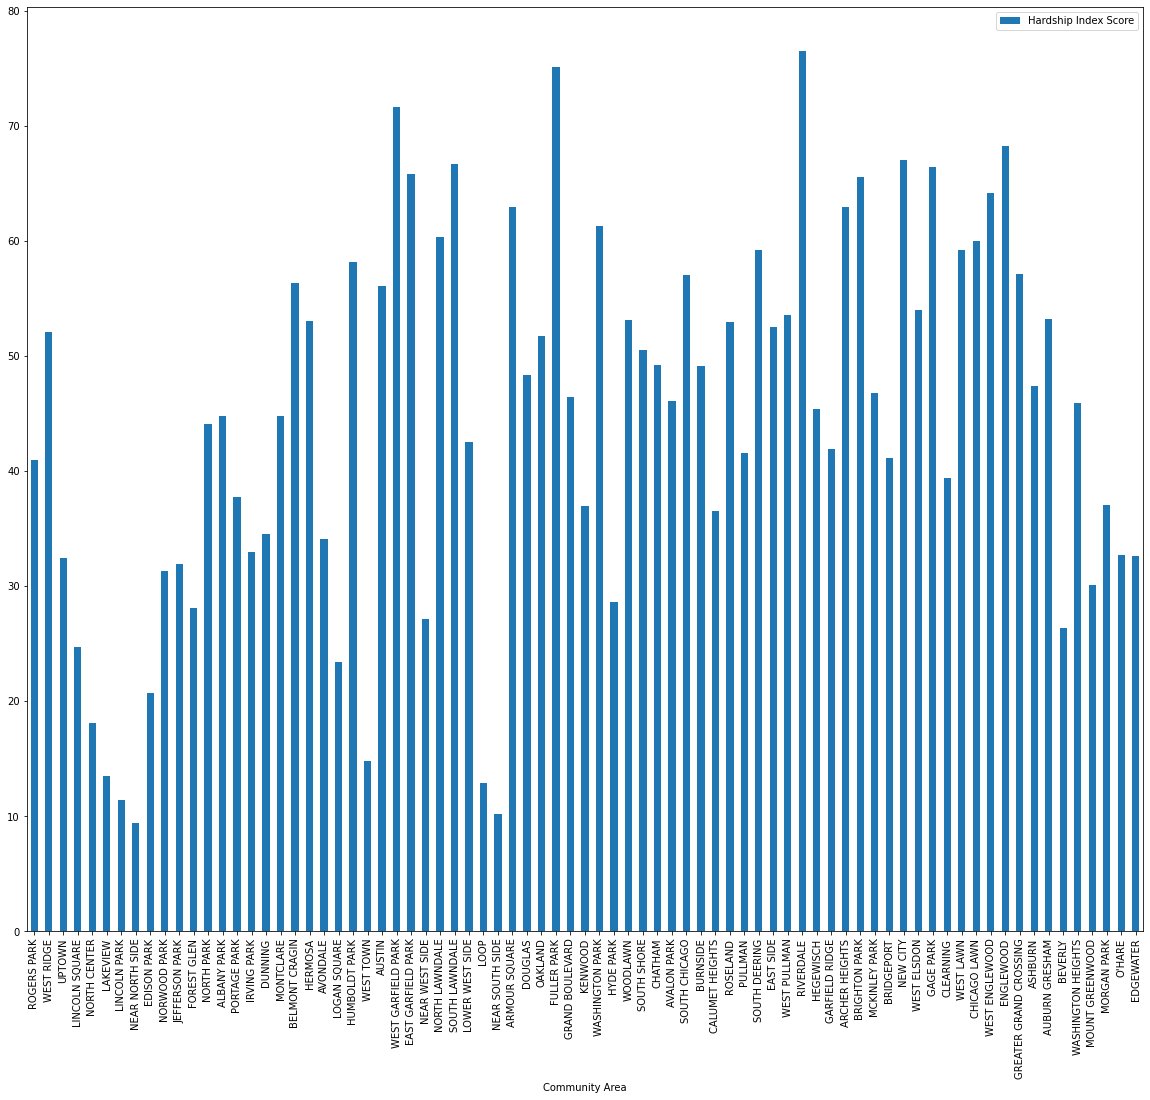

In [25]:
hardship.plot(kind = 'bar', x='Community Area', y='Hardship Index Score', figsize = (20,17))

In [27]:
# Standardize area names for hardship dataset
replace_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront'}
replace_hardship_df = {'EAST GARFIELD PARK': 'GARFIELD PARK', 'WEST GARFIELD PARK': 'GARFIELD PARK', 'DOUGLAS': 'Bronzeville/South Lakefront', 'GRAND BOULEVARD': 'Bronzeville/South Lakefront', 'OAKLAND': 'Bronzeville/South Lakefront', 'SOUTH LAWNDALE': 'Little Village', 'NEW CITY': 'Back of the Yards', 'LAKEVIEW': 'LAKE VIEW', "O'HARE":'OHARE', 'CLEARNING':'CLEARING'}
grouped['Geographic Cluster Name'] = grouped['Geographic Cluster Name'].replace(replace_df)
hardship['Community Area'] = hardship['Community Area'].replace(replace_hardship_df)

# Merge datasets
full_df = pd.merge(merge, hardship, left_on = 'Geographic Cluster Name', right_on = 'Community Area', how = 'left')

In [28]:
full_df = full_df.drop(['Community Area', 'Unnamed: 9'], axis=1)

In [29]:
full_df['Capacity Per Capita'] = full_df['Total Capacity'].astype(int) / full_df['population'].astype(int)
full_df = full_df.drop('name', axis=1)

In [30]:
full_df.to_csv('Merged_Dataset.csv')

In [31]:
full_df

,Geographic Cluster Name,Category Name,Meeting Type,Total Programs,Total Capacity,Average Max Age,Average Latitude,Average Capacity,population,income,...,other,No.,Percent of rowded Housing,Percent of Households With Income Below Poverty Level,Unemployment Rate for Population over 16,Percent Aged 25 and Over with no High School Diploma,Percent of Population Under Age 18 and Over Age 64,Per Capita Income,Hardship Index Score,Capacity Per Capita
0,ALBANY PARK,Academic Support,face_to_face,14,210.0,7.928571,41.973703,15.000000,51542,46198,...,0.029,14,6.40%,12.60%,6.60%,19.30%,31.70%,"$32,298",44.8,0.004074
1,ALBANY PARK,Building & Fixing Things,face_to_face,1,99.0,99.000000,41.968399,99.000000,51542,46198,...,0.029,14,6.40%,12.60%,6.60%,19.30%,31.70%,"$32,298",44.8,0.001921
2,ALBANY PARK,Computers.,face_to_face,5,3930.0,18.600000,41.968393,786.000000,51542,46198,...,0.029,14,6.40%,12.60%,6.60%,19.30%,31.70%,"$32,298",44.8,0.076248
3,ALBANY PARK,Healthcare,face_to_face,2,20.0,99.000000,41.973715,10.000000,51542,46198,...,0.029,14,6.40%,12.60%,6.60%,19.30%,31.70%,"$32,298",44.8,0.000388
4,ALBANY PARK,Music & Art.,face_to_face,187,38557.0,51.443850,41.970875,206.187166,51542,46198,...,0.029,14,6.40%,12.60%,6.60%,19.30%,31.70%,"$32,298",44.8,0.748070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,WOODLAWN,Science,face_to_face,4,1012.0,12.000000,41.780102,253.000000,23740,27413,...,0.02,42,4.00%,31.10%,15.90%,12.70%,33.80%,"$22,457",53.1,0.042628
1561,WOODLAWN,Science,online,1,18.0,99.000000,NaN,18.000000,23740,27413,...,0.02,42,4.00%,31.10%,15.90%,12.70%,33.80%,"$22,457",53.1,0.000758
1562,WOODLAWN,Sports + Wellness.,face_to_face,281,4999.0,52.345196,41.781087,17.790036,23740,27413,...,0.02,42,4.00%,31.10%,15.90%,12.70%,33.80%,"$22,457",53.1,0.210573
1563,WOODLAWN,Sports + Wellness.,online,23,332.0,55.869565,41.781738,14.434783,23740,27413,...,0.02,42,4.00%,31.10%,15.90%,12.70%,33.80%,"$22,457",53.1,0.013985


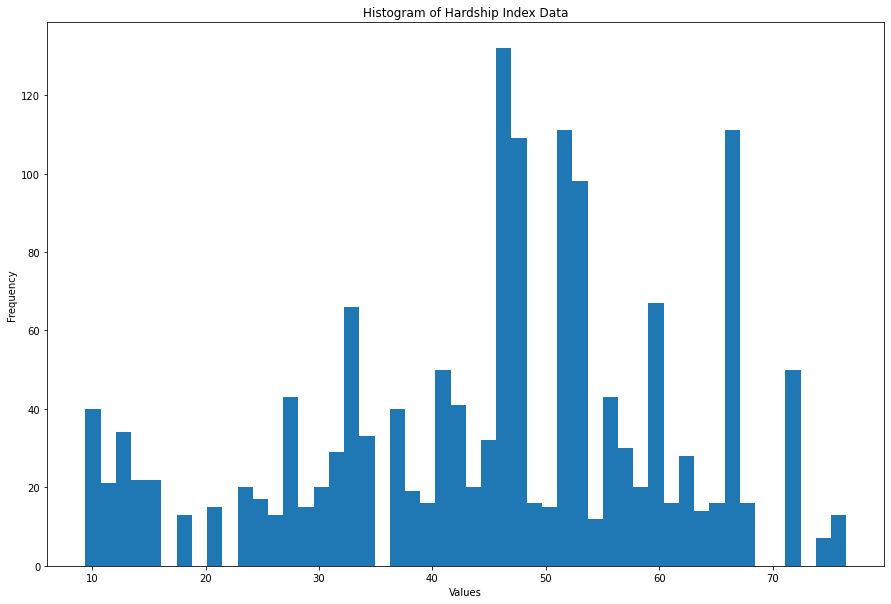

In [40]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(15, 10))
plt.hist(full_df['Hardship Index Score'], bins = 50)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Hardship Index Data')

# Show the plot
plt.show()


array([[<AxesSubplot:xlabel='Total Programs', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='Total Capacity', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='Average Max Age', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='Average Latitude', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='Average Capacity', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='No.', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='Hardship Index Score', ylabel='Total Programs'>,
        <AxesSubplot:xlabel='Capacity Per Capita', ylabel='Total Programs'>],
       [<AxesSubplot:xlabel='Total Programs', ylabel='Total Capacity'>,
        <AxesSubplot:xlabel='Total Capacity', ylabel='Total Capacity'>,
        <AxesSubplot:xlabel='Average Max Age', ylabel='Total Capacity'>,
        <AxesSubplot:xlabel='Average Latitude', ylabel='Total Capacity'>,
        <AxesSubplot:xlabel='Average Capacity', ylabel='Total Capacity'>,
        <AxesSubplot:xlabel='No.', ylabel='Total Capa

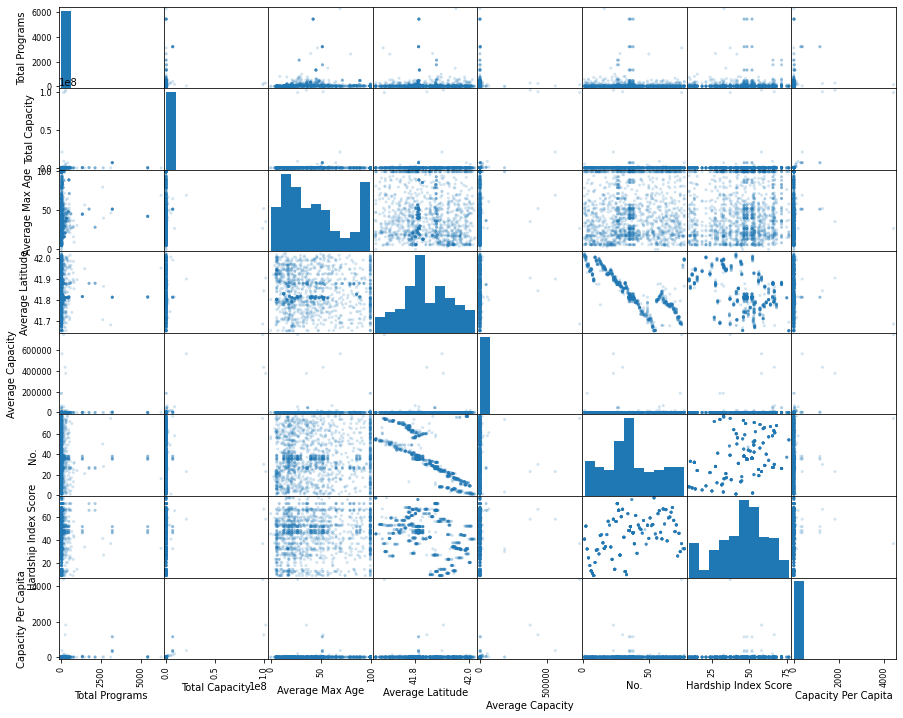

In [71]:
pd.plotting.scatter_matrix(full_df, alpha=0.2, figsize=(15,12), diagonal='hist')

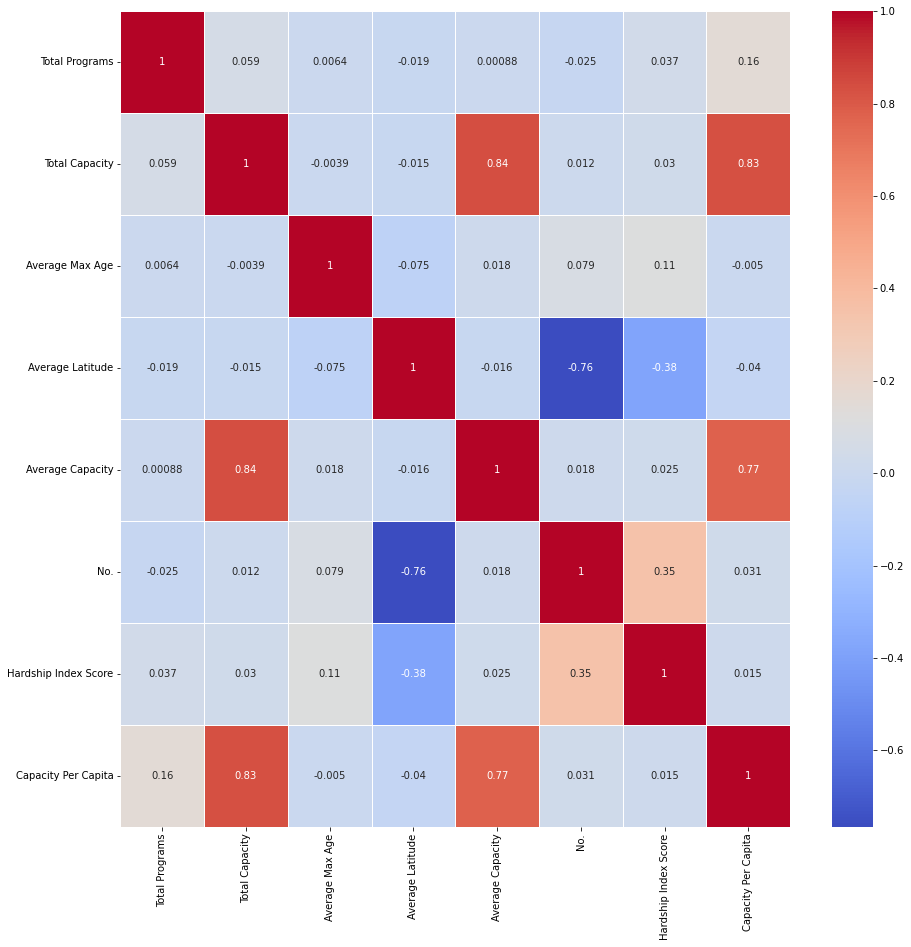

In [81]:
corr_matrix = full_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidth=.5)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]),
 [Text(0, 0, 'ALBANY PARK'),
  Text(1, 0, 'ARCHER HEIGHTS'),
  Text(2, 0, 'ARMOUR SQUARE'),
  Text(3, 0, 'ASHBURN'),
  Text(4, 0, 'AUBURN GRESHAM'),
  Text(5, 0, 'AUSTIN'),
  Text(6, 0, 'AVALON PARK'),
  Text(7, 0, 'AVONDALE'),
  Text(8, 0, 'BELMONT CRAGIN'),
  Text(9, 0, 'BEVERLY'),
  Text(10, 0, 'BRIDGEPORT'),
  Text(11, 0, 'BRIGHTON PARK'),
  Text(12, 0, 'BURNSIDE'),
  Text(13, 0, 'Back of the Yards'),
  Text(14, 0, 'Bronzeville/South Lakefront'),
  Text(15, 0, 'CALUMET HEIGHTS'),
  Text(16, 0, 'CHATHAM'),
  Text(17, 0, 'CHICAGO LAWN'),
  Text(18, 0, 'CLEARING'),
  Text(19, 0, 'DUNNING'),
  Text(20, 0, 'EAST SIDE'),
  Text(21, 0, 'EDGEWATER'),
  Text(

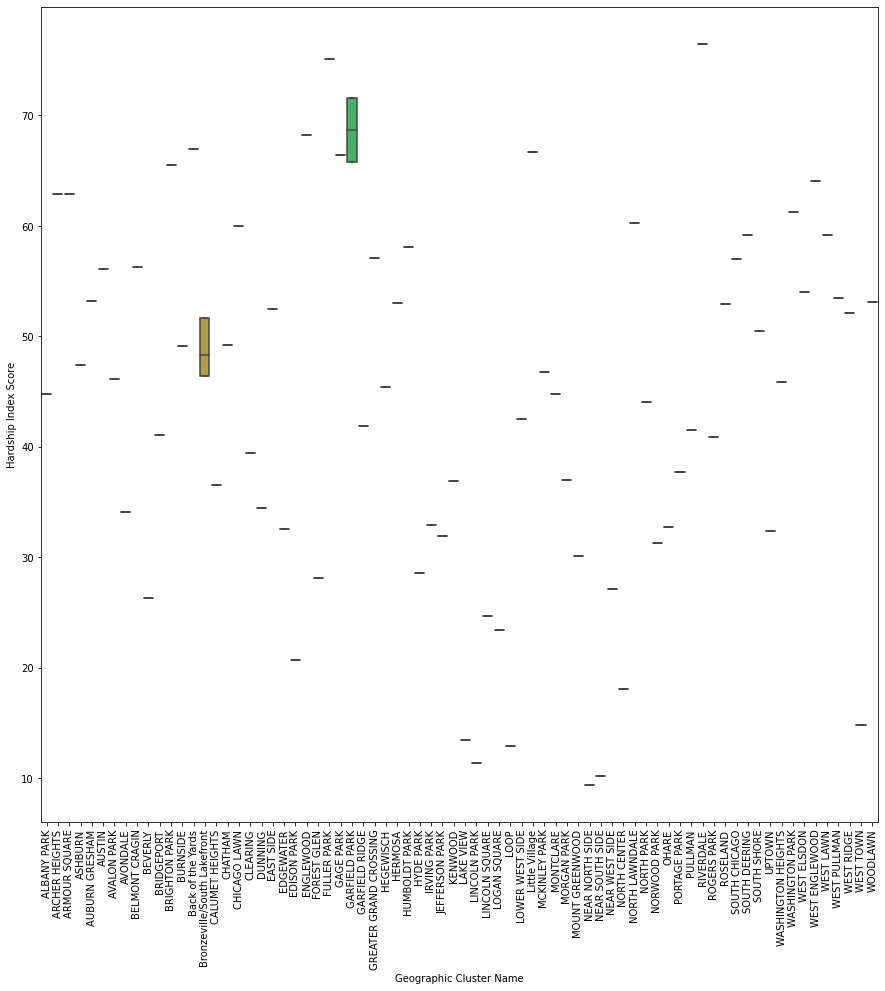

In [101]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(x='Geographic Cluster Name', y='Hardship Index Score', data=full_df)

In [96]:
full_df['Category Name'].unique()

array(['Academic Support', 'Building & Fixing Things', 'Computers.',
       'Healthcare', 'Music & Art.', 'Nature.', 'Reading & Writing.',
       'Science ', 'Sports + Wellness.', 'Food.',
       'Helping Your Community.', 'Performance.', 'Work + Career ',
       'Math', 'Social Studies ', 'Managing Money.',
       'Customer/Human Service', 'Digital Media.', 'Teaching', 'Law',
       'Transportation'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Academic Support'),
  Text(1, 0, 'Building & Fixing Things'),
  Text(2, 0, 'Computers.'),
  Text(3, 0, 'Healthcare'),
  Text(4, 0, 'Music & Art.'),
  Text(5, 0, 'Nature.'),
  Text(6, 0, 'Reading & Writing.'),
  Text(7, 0, 'Science '),
  Text(8, 0, 'Sports + Wellness.'),
  Text(9, 0, 'Food.'),
  Text(10, 0, 'Helping Your Community.'),
  Text(11, 0, 'Performance.'),
  Text(12, 0, 'Work + Career '),
  Text(13, 0, 'Math'),
  Text(14, 0, 'Social Studies '),
  Text(15, 0, 'Managing Money.'),
  Text(16, 0, 'Customer/Human Service'),
  Text(17, 0, 'Digital Media.'),
  Text(18, 0, 'Teaching'),
  Text(19, 0, 'Law'),
  Text(20, 0, 'Transportation')])

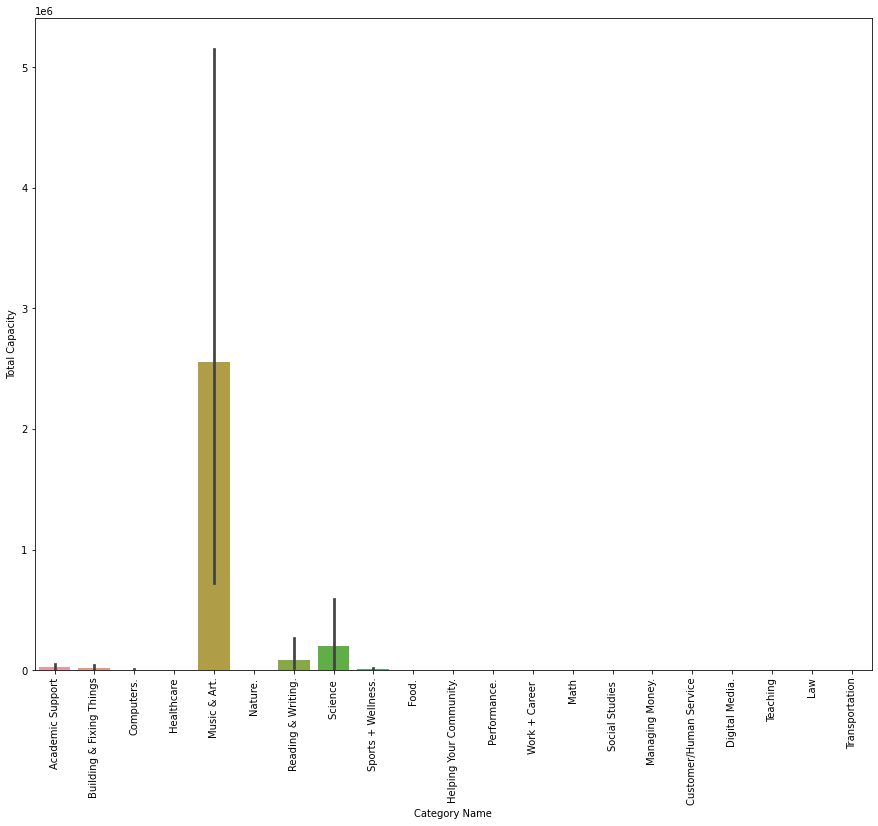

In [102]:
fig, ax = plt.subplots(figsize=(15,12))
sns.barplot(x='Category Name', y='Total Capacity', data=full_df)
plt.xticks(rotation=90)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(x='Meeting Type', y='Average Capacity', data=full_df)